## Предобработка данных, сгенерированных из Матлаба

In [1]:
import sys
import os
from pathlib import Path
from typing import Union, NoReturn, Sequence, Optional

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from scipy import signal
import scipy.io
from einops import rearrange
import matplotlib.pyplot as plt

sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils import data_utils
from utils import losses, hand_visualize
from utils.quats_and_angles import get_angles, get_quats
from models import HVATNet_v3_FineTune

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def get_subdirs(rootdir):
    paths = []
    for path in Path(rootdir).iterdir():
        if path.is_dir():
            paths.append(path)
    return paths


config = dict(
    original_fps=200,
    delay_ms=0,  # Shift vr vs EMG parameter. ms dealy between emg and VR.
    start_crop_ms=0,  # bad values in the beginning of recordign in ms to delete.
    window_size=256,
)
config = AttrDict(config)

### Пример одной записи из реальных данных

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

path = r"D:\study\emg-virtual\data\Nastya\Simple\Raw\Simple1\1\1.0_data_test_057393.npz"
data = np.load(path)

one_c = data["data_myo"][:, 0]
vr = data["data_vr"][:, :, 4:8]
one_channel = vr[:, 1, 3]
quats = data["data_vr"][:, :, 4:8]

plt.figure(figsize=(10, 10))
plt.subplot(5, 1, 1)
plt.plot(one_c[~np.isnan(one_c)])
plt.title("EMG Data")

plt.subplot(5, 1, 2)
plt.plot(data["myo_ts"])
plt.title("EMG Time Stamps")

plt.subplot(5, 1, 3)
plt.plot(data["vr_ts"])
plt.title("VR Time Stamps")

plt.subplot(5, 1, 4)
plt.plot(one_channel[~np.isnan(one_channel)])
plt.title("VR Quaternion one channel")

plt.subplot(5, 1, 5)
plt.plot(quats[:, 5, 0])
plt.title("VR Quaternion")

plt.tight_layout()

print("EMG shape:", data["data_myo"].shape)
print("Time Stamps EMG shape:", data["myo_ts"].shape)
print("VR shape:", data["data_vr"].shape)
print("Time Stamps VR shape:", data["vr_ts"].shape)

### Пример одной записи из сгенерированных данных

s shape: (8, 599001) s_env shape: (8, 599001) t shape: (1, 599001) vel1 shape: (20, 599001) vel2 shape: (20, 599001)


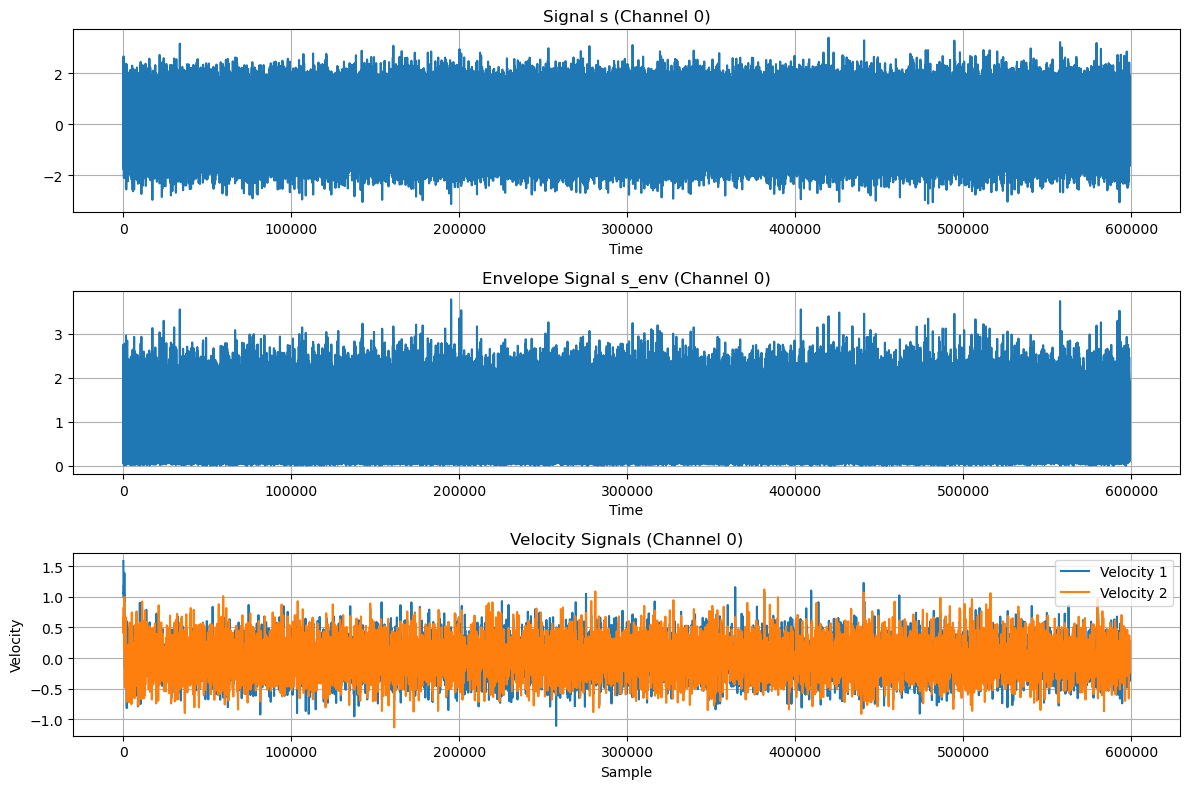

In [2]:
def load_data_from_mat(path, variable_name):
    mat_content = scipy.io.loadmat(path)
    mat_variable = mat_content[variable_name]
    return np.array(mat_variable)


Fs = 500  # sampling frequency . Set to your value
T = 1200  # total time of the simulation, seconds - set you value, you can
N_EMG = 8  # number of EMG channels
N_joints = 20  # number of decodede angles

path = "../gen_data/v2/"
s = load_data_from_mat(os.path.join(path, "./s.mat"), "s")
s_env = load_data_from_mat(os.path.join(path, "./s_env.mat"), "s_env")
s_env = s_env[:, Fs : -(Fs - 1)]  # Обержем согласно том, как это делается в matlab

t = load_data_from_mat(os.path.join(path, "./t.mat"), "t")
t = t[:, Fs : -(Fs - 1)]  # Обержем согласно том, как это делается в matlab

vel1 = load_data_from_mat(os.path.join(path, "./vel1.mat"), "vel1")
vel2 = load_data_from_mat(os.path.join(path, "./vel2.mat"), "vel2")

print(
    f"s shape: {s.shape} s_env shape: {s_env.shape} t shape: {t.shape} vel1 shape: {vel1.shape} vel2 shape: {vel2.shape}"
)
# Поскольку массивы имеют 2D структуру, выберем для примера один из каналов
channel_index = 0

plt.figure(figsize=(12, 8))

# График для s
plt.subplot(3, 1, 1)
plt.plot(s[channel_index, :])
plt.title(f"Signal s (Channel {channel_index})")
plt.xlabel("Time")
# plt.ylabel("Amplitude")
plt.grid(True)

# График для s_env
plt.subplot(3, 1, 2)
plt.plot(s_env[channel_index, :])
plt.title(f"Envelope Signal s_env (Channel {channel_index})")
plt.xlabel("Time")
# plt.ylabel("Amplitude")
plt.grid(True)

# График велосити vel1 и vel2 для одного канала
plt.subplot(3, 1, 3)
plt.plot(vel1[channel_index, :], label="Velocity 1")
plt.plot(vel2[channel_index, :], label="Velocity 2")
plt.title(f"Velocity Signals (Channel {channel_index})")
plt.xlabel("Sample")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Предобработка данных

In [3]:
data = {"myo": s.T, "angles1": vel1.T, "angles2": vel2.T, "ts": t.T}

# Переходим от частоты 500Гц в частоту 250Гц
data["myo"] = data["myo"][::2]
data["angles1"] = data["angles1"][::2]
data["angles2"] = data["angles2"][::2]
data["ts"] = data["ts"][::2]

In [4]:
data["myo"].shape

(299501, 8)

In [5]:
# Фильтрация данных
empty = np.empty(data["myo"].shape)  # data["myo"].shape = (4501, 8)

std_range = 6

for electrode in range(data["myo"].shape[1]):
    da = data["myo"][:, electrode]
    dat = da[~np.isnan(da)]

    samp_freq = 250  # Sample frequency (Hz)
    notch_freq = 50.0  # Frequency to be removed from signal (Hz)
    quality_factor = 30.0  # Quality factor

    b_notch, a_notch = scipy.signal.iirnotch(notch_freq, quality_factor, samp_freq)
    freq, h = scipy.signal.freqz(b_notch, a_notch, fs=samp_freq)

    emg_filt = scipy.signal.filtfilt(b_notch, a_notch, dat)
    emg_filt_norm = data_utils.butter_highpass_filter(emg_filt, 10, 125, order=5)
    diff_in_length = len(da) - len(emg_filt_norm)
    emg_filt_norm = np.append(emg_filt_norm, np.zeros(diff_in_length) + np.nan)

    empty[:, electrode] = emg_filt_norm

# Удаление выбросов
cleanest = np.empty(data["myo"].shape)
std_threshold = std_range * np.max(np.nanstd(empty, axis=0))

for electrode in range(data["myo"].shape[1]):
    one_signal = empty[:, electrode]
    one_signal_clean = one_signal[~np.isnan(one_signal)]

    clear_up = np.where(
        one_signal_clean < std_threshold, one_signal_clean, std_threshold
    )
    clear_down = np.where(clear_up > -1 * std_threshold, clear_up, -1 * std_threshold)

    diff_in_length = len(one_signal) - len(clear_down)
    final_signal = np.append(clear_down, np.zeros(diff_in_length) + np.nan)
    cleanest[:, electrode] = final_signal

# MinMax нормализация
maxx = np.nanmax(cleanest)
minn = np.nanmin(cleanest)

# normalize data based on the whole set of signals.
# EMG preproc: normalize -> (-1, 1) range as audio.
emg_min_max = (cleanest - minn) / (maxx - minn)  # (0, 1)
emg_min_max = 2 * emg_min_max - 1

# I do scaling on the whole dataset, but that creates vertical shifts (+- 0.2) in data, so i substract this shift
data_myo = emg_min_max - np.nanmean(emg_min_max, axis=0)
data["myo"] = data_myo

Создаем класс датасета

In [6]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)


# Определяем класс Dataset
class EMGDataset(Dataset):
    def __init__(
        self, emg_data, angles_data, window_size=256, stride=256, downsample_target=8
    ):
        assert len(emg_data) == len(
            angles_data
        ), "Data and target lengths do not match."

        self.emg_data = emg_data
        self.angles_data = angles_data
        self.window_size = window_size
        self.stride = stride
        self.downsample_target = downsample_target

        # Calculate the number of possible segments
        self.num_samples = (len(emg_data) - window_size) // stride + 1

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.window_size

        emg_sample = self.emg_data[start:end]
        angles_sample = self.angles_data[start:end]

        if self.downsample_target:
            angles_sample = angles_sample[:: self.downsample_target]

        emg_sample_tensor = torch.tensor(emg_sample, dtype=torch.float32).transpose(
            0, 1
        )
        angles_sample_tensor = torch.tensor(
            angles_sample, dtype=torch.float32
        ).transpose(0, 1)

        return emg_sample_tensor, angles_sample_tensor


# Определение размера обучения
train_size = int(0.8 * len(data["myo"]))

# Разделение данных на трейн и тест
train_emg_data = data["myo"][:train_size]
test_emg_data = data["myo"][train_size:]

train_angles_data = data["angles2"][:train_size]
test_angles_data = data["angles2"][train_size:]

# Проверка форм
print("Train Data Shape:", train_emg_data.shape)
print("Test Data Shape:", test_emg_data.shape)

# Создаем экземпляр Dataset
train_dataset = EMGDataset(
    train_emg_data, train_angles_data, window_size=256, stride=128, downsample_target=8
)
test_dataset = EMGDataset(
    test_emg_data, test_angles_data, window_size=256, stride=128, downsample_target=8
)

# Используем встроенный DataLoader
batch_size = 256
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True
)

# Пример получения данных из train_loader
for emg_batch, angles_batch in train_loader:
    print("Train EMG Batch Shape:", emg_batch.shape)  # Ожидается: (batch_size, 8, 256)
    print(
        "Train Angles Batch Shape:", angles_batch.shape
    )  # Ожидается: (batch_size, 20, 256)
    break  # Выводим только первую итерацию для примера

# Пример получения данных из test_loader
for emg_batch, angles_batch in test_loader:
    print("Test EMG Batch Shape:", emg_batch.shape)  # Ожидается: (batch_size, 8, 256)
    print(
        "Test Angles Batch Shape:", angles_batch.shape
    )  # Ожидается: (batch_size, 20, 256)
    break  # Выводим только первую итерацию для примера

Train Data Shape: (239600, 8)
Test Data Shape: (59901, 8)
Train EMG Batch Shape: torch.Size([256, 8, 256])
Train Angles Batch Shape: torch.Size([256, 20, 32])
Test EMG Batch Shape: torch.Size([256, 8, 256])
Test Angles Batch Shape: torch.Size([256, 20, 32])


Полносвязная нейронная сеть

In [8]:
# Определение устройства (CPU или CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение архитектуры нейронной сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.model(x)


# Параметры сети
input_size = (
    8 * 256
)  # Предполагается, что вход имеет размер 8 каналов x 256 временных шагов
hidden_size = 512
output_size = 20 * 32  # Ожидаемый размер выхода

# Перенос модели на выбранное устройство
model = MLP(input_size, hidden_size, output_size).to(device)
print(f"Model is using device: {device}")

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Обучение модели
num_epochs = 100

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    for emg_batch, angles_batch in train_loader:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

Model is using device: cuda


c:\Users\laput\miniconda3\envs\pcb\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([256, 20, 32])) that is different to the input size (torch.Size([256, 640])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (640) must match the size of tensor b (32) at non-singleton dimension 2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Определение устройства (CPU или CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение модели с полносвязной нейронной сетью
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=128, output_channels=20, output_sequence_length=32):
        super(FullyConnectedModel, self).__init__()
        self.flatten = nn.Flatten()
        # Входной слой: 8 входных каналов * 256 временных шагов
        self.fc1 = nn.Linear(input_size * 256, hidden_size)
        self.relu = nn.ReLU()
        # Выходной слой должен формировать 20 каналов, каждый из 32 элементов
        self.fc2 = nn.Linear(hidden_size, output_channels * output_sequence_length)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # Перестроим тензор в форму (batch_size, output_channels, output_sequence_length)
        x = x.view(x.size(0), 20, 32)
        return x

# Создание модели и перенесение ее на устройство
model = FullyConnectedModel(input_size=8, hidden_size=128, output_channels=20, output_sequence_length=32).to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Количество эпох
num_epochs = 100

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )


NameError: name 'train_loader' is not defined

In [14]:
angles_batch.shape

torch.Size([256, 20, 32])

In [13]:
outputs.shape

torch.Size([256, 32])

BidirectionalLSTM

In [ ]:
# Определение устройства (CPU или CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение модели с Bidirectional LSTM
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=1, output_size=20):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dense = nn.Linear(hidden_size * 2, output_size)  # *2 для двунаправленной LSTM
        self.pool = nn.AvgPool1d(kernel_size=8, stride=8)  # Уменьшение длины в 8 раз

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Перемещение размерностей на (batch, seq_length, input_size)
        out, _ = self.lstm(x)
        out = self.dense(out)
        out = out.permute(0, 2, 1)  # Вернуть к (batch, output_size, sequence_length)
        out = self.pool(out)
        return out

# Создание модели и перенесение ее на устройство
model = BidirectionalLSTMModel().to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Обучение модели
num_epochs = 20

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

Epoch [1/20], Train Loss: 0.2012, Validation Loss: 0.1988


Epoch [2/20], Train Loss: 0.1997, Validation Loss: 0.1973


Epoch [3/20], Train Loss: 0.1981, Validation Loss: 0.1959


Epoch [4/20], Train Loss: 0.1967, Validation Loss: 0.1947


Epoch [5/20], Train Loss: 0.1957, Validation Loss: 0.1937


Epoch [6/20], Train Loss: 0.1947, Validation Loss: 0.1927


Epoch [7/20], Train Loss: 0.1939, Validation Loss: 0.1919


Epoch [8/20], Train Loss: 0.1932, Validation Loss: 0.1911


Epoch [9/20], Train Loss: 0.1922, Validation Loss: 0.1905


Epoch [10/20], Train Loss: 0.1918, Validation Loss: 0.1900


Epoch [11/20], Train Loss: 0.1911, Validation Loss: 0.1896


Epoch [12/20], Train Loss: 0.1908, Validation Loss: 0.1892


Epoch [13/20], Train Loss: 0.1905, Validation Loss: 0.1890


Epoch [14/20], Train Loss: 0.1904, Validation Loss: 0.1888


Epoch [15/20], Train Loss: 0.1902, Validation Loss: 0.1887


Epoch [16/20], Train Loss: 0.1900, Validation Loss: 0.1886


Epoch [17/20], Train Loss: 0.1899, Validation Loss: 0.1885


Epoch [18/20], Train Loss: 0.1898, Validation Loss: 0.1885


Epoch [19/20], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [20/20], Train Loss: 0.1896, Validation Loss: 0.1884


HvatNetV3

In [ ]:
hvatnet_v3_params = dict(
    n_electrodes=8,
    n_channels_out=20,
    n_res_blocks=3,
    n_blocks_per_layer=3,
    n_filters=128,
    kernel_size=3,
    strides=(2, 2, 2),
    dilation=2,
    use_angles=True,
)

# Определение устройства (CPU или CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создание модели и перенесение ее на устройство
model = HVATNet_v3_FineTune.HVATNetv3(**hvatnet_v3_params).to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Обучение модели
num_epochs = 20

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

In [ ]:
state = {
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_loss": average_train_loss,
    "val_loss": average_val_loss,
}

model_path = "../checkpoints/hvatnet-0311.pth"
torch.save(state, model_path)

In [ ]:
with torch.no_grad():
    for emg_batch, angles_batch in test_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        break

In [ ]:
angles_batch

In [ ]:
outputs

In [ ]:
outputs.shape, angles_batch.shape

In [ ]:
with torch.no_grad():
    for emg_batch, angles_batch in train_loader:
        emg_batch = emg_batch.to(device)
        outputs = model(emg_batch)
        print("Model Output Size:", outputs.size())
        break  # Только для первого батча

### Справочник

In [ ]:
import numpy as np


def calc_probas(iterable) -> list:
    lens = []
    for child_iter in iterable:
        lens.append(len(child_iter))
    probas = np.array(lens) / sum(lens)
    return probas


data_example = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]  # длина 3  # длина 2  # длина 4

probabilities = calc_probas(data_example)
print(probabilities)  # Выдаст: [0.3, 0.2, 0.5]

In [ ]:
def calc_stripped_len(sequence, window_size: int) -> int:
    return int((len(sequence) // window_size) * window_size)


sequence_example = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # длина 9
window_size = 4

stripped_length = calc_stripped_len(sequence_example, window_size)
print(stripped_length)  # Выдаст: 8

Снижение частоты дискретизации с помощью MNE

In [ ]:
import mne
import numpy as np

# Simulate loading EMG data
sfreq = 500
n_channels = 1
n_times = 9001
data = s[:1, :]

# Create an MNE RawArray
info = mne.create_info(ch_names=["EMG"], sfreq=sfreq, ch_types=["emg"])
raw = mne.io.RawArray(data, info)

# Downsample data to 250 Hz
new_sfreq = 250  # target new frequency
raw.resample(new_sfreq, npad="auto")

# Convert the resampled data to a NumPy array
resampled_data = raw.get_data()

# For demonstration purposes, let's show the shape and the first few samples
print(f"New sampling frequency: {raw.info['sfreq']} Hz")
print(f"Data shape after resampling: {resampled_data.shape}")
print(f"First few samples of resampled data:\n{resampled_data[:, :10]}")

In [ ]:
np.random.randn(n_channels, n_times)

In [ ]:
s[:1, :]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter


def manual_decimate(data, q):
    # Создание FIR фильтра для предварительной обработки
    numtaps = 15  # Порядок фильтра
    cutoff = 0.5 / q  # Нормированная отсечка по частоте
    b = firwin(numtaps, cutoff, window="hamming")

    # Фильтрация
    filtered_data = lfilter(b, 1.0, data)

    # Децимация
    return filtered_data[::q]


# Сгенерируем случайные данные
Fs = 500  # Исходная частота дискретизации
t = np.linspace(0, 10, 9001)  # 10 секунд данных с частотой 500 Гц
data = np.sin(2 * np.pi * 10 * t) + np.random.normal(0, 0.5, t.shape)

# Децимация с уменьшением частоты
Q = 2
decimated_data = manual_decimate(data, Q)

# Создание временных осей для графиков
t_decimated = t[::Q]

# Визуализация
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t, data, label="Исходный сигнал")
plt.title("Сигнал с частотой дискретизации 500 Гц")
plt.xlabel("Время [с]")
plt.ylabel("Амплитуда")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_decimated, decimated_data, "r", label="Децимированный сигнал")
plt.title("Сигнал с частотой дискретизации 250 Гц")
plt.xlabel("Время [с]")
plt.ylabel("Амплитуда")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Годный сигнал и шум
t = np.linspace(0, 1, 500, endpoint=False)
signal = np.sin(2 * np.pi * 30 * t) + np.sin(2 * np.pi * 80 * t)

# Пример выборки вдвое без фильтрации
sampled_signal = signal[::2]

# Визуализация
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(t, signal, label="Исходный сигнал")
plt.title("Исходный сигнал")
plt.xlabel("Время [с]")
plt.ylabel("Амплитуда")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t[: len(sampled_signal)], sampled_signal, "r", label="Выборочно вдвое")
plt.title("Выборочно вдвое без фильтрации")
plt.xlabel("Время [с]")
plt.ylabel("Амплитуда")
plt.grid(True)

plt.tight_layout()
plt.show()

Огибающая сигнала

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Создание временной оси
Fs = 1000  # частота дискретизации
T = 1  # общее время
t = np.linspace(0, T, int(Fs * T), endpoint=False)

# Создание синусоидального сигнала с плавно меняющейся амплитудой
carrier_freq = 10  # частота несущего сигнала
amplitude = np.sin(2 * np.pi * 0.5 * t) + 1.5  # медленно меняющаяся амплитуда

# Сигнал
s = amplitude * np.sin(2 * np.pi * carrier_freq * t)

# Аналитический сигнал и огибающая
analytic_signal = hilbert(s)
amplitude_envelope = np.abs(analytic_signal)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(t, s, label="Сигнал $s(t)$")
plt.plot(
    t,
    amplitude_envelope,
    label="Огибающая $s_{env}(t)$",
    linewidth=2,
    linestyle="--",
    color="red",
)

plt.title("Сигнал и его огибающая")
plt.xlabel("Время [с]")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True)
plt.show()